In [64]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
from sklearn.linear_model import \
     (LinearRegression,
      LogisticRegression,
      Lasso)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from sklearn.model_selection import \
     (train_test_split,
      GridSearchCV)
from torch.optim import Adam

In [2]:
import numpy as np, pandas as pd, random, torch
from pytorch_lightning import seed_everything

seed_everything(57, workers=True)
torch.use_deterministic_algorithms(True, warn_only=True)

Seed set to 57


In [3]:
import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset

In [4]:
from torchmetrics import (MeanAbsoluteError,
                          R2Score)
from torchinfo import summary
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger

In [5]:
from ISLP.torch import (SimpleDataModule,
                        SimpleModule,
                        ErrorTracker,
                        rec_num_workers)
from ISLP.torch.imdb import (load_lookup,
                             load_tensor,
                             load_sparse,
                             load_sequential)

## Question 1

part A

In [6]:
# load wage data
wage = load_data('Wage')
wage.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [7]:

D = wage[['year','age','education','jobclass']].copy()
X = np.asarray(D)
y = np.array(wage['wage'])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=57
)

In [8]:
# Standardize features for training data

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled[:, [0, 1]] = scaler.fit_transform(X_train[:, [0, 1]].astype(float))

# Scale target variable (y_train is 1D, so we need to reshape)
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()


In [9]:
# Convert categorical variables to numeric for X_train_scaled
from sklearn.preprocessing import LabelEncoder

# Create copies to avoid modifying original data
X_train_encoded = X_train_scaled.copy()
X_test_encoded = X_test.copy()

# Encode categorical variables for training data
le_education = LabelEncoder()
le_jobclass = LabelEncoder()

# Fit on training data and transform both train and test
X_train_encoded[:, 2] = le_education.fit_transform(X_train_scaled[:, 2])
X_train_encoded[:, 3] = le_jobclass.fit_transform(X_train_scaled[:, 3])

# Apply same encoding to test data
X_test_encoded[:, 2] = le_education.transform(X_test[:, 2])
X_test_encoded[:, 3] = le_jobclass.transform(X_test[:, 3])

# Scale the continuous features in test data using the same scaler
X_test_encoded[:, [0, 1]] = scaler.transform(X_test[:, [0, 1]].astype(float))

# Convert to tensors
X_train_t = torch.tensor(X_train_encoded.astype(np.float32)) # Convert training features to PyTorch tensor.
Y_train_t = torch.tensor(y_train_scaled.astype(np.float32)) # Convert training targets to PyTorch tensor.
TensorDataset_train = TensorDataset(X_train_t, Y_train_t)

X_test_t = torch.tensor(X_test_encoded.astype(np.float32)) # Convert test features to PyTorch tensor.
Y_test_t = torch.tensor(y_test.astype(np.float32)) # Convert test targets to PyTorch tensor.
TensorDataset_test = TensorDataset(X_test_t, Y_test_t)

In [10]:
max_num_workers = rec_num_workers()

In [11]:
wage_dm = SimpleDataModule(TensorDataset_train,
                          TensorDataset_test,
                          batch_size=64,
                          validation=0.25,
                          num_workers=min(4, max_num_workers),
                          )


In [12]:
# Print shapes of one training batch
wage_dm.setup('fit')  # Setup the data module for training
train_loader = wage_dm.train_dataloader()

# Get one batch from the training loader
for X_, Y_ in train_loader:
    print(f"Training batch shapes:")
    print(f"X_ (features) shape: {X_.shape}")
    print(f"Y_ (targets) shape: {Y_.shape}")
    break  # Only get the first batch

Training batch shapes:
X_ (features) shape: torch.Size([64, 4])
Y_ (targets) shape: torch.Size([64])


part B

In [58]:
class WageModel(nn.Module):
    def __init__(self, input_dim): 
        
        super(WageModel, self).__init__() # Initialize the parent class.
        self.layer1 = nn.Sequential( 
            nn.Flatten(),
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3)) # First layer: Flatten input images, pass through a fully connected layer, then apply ReLU activation and dropout.
        self.layer2 = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3)) # Second layer: Fully connected layer, ReLU activation, and dropout.
        self._forward = nn.Sequential(
            self.layer1,
            self.layer2,
            nn.Linear(32, 1)) # Output layer: Fully connected layer mapping to a single output.
    def forward(self, x): 
        return self._forward(x).flatten() # Define the forward pass through the network.

In [59]:
input_dim = X_train_t.shape[1]
wage_model = WageModel(input_dim)
summary(wage_model, input_size=(64, input_dim))

Layer (type:depth-idx)                   Output Shape              Param #
WageModel                                [64]                      --
├─Sequential: 1-1                        [64, 1]                   --
│    └─Sequential: 2-1                   [64, 64]                  --
│    │    └─Flatten: 3-1                 [64, 4]                   --
│    │    └─Linear: 3-2                  [64, 64]                  320
│    │    └─ReLU: 3-3                    [64, 64]                  --
│    │    └─Dropout: 3-4                 [64, 64]                  --
│    └─Sequential: 2-2                   [64, 32]                  --
│    │    └─Linear: 3-5                  [64, 32]                  2,080
│    │    └─ReLU: 3-6                    [64, 32]                  --
│    │    └─Dropout: 3-7                 [64, 32]                  --
│    └─Linear: 2-3                       [64, 1]                   33
Total params: 2,433
Trainable params: 2,433
Non-trainable params: 0
Total mult-ad

part C

In [69]:
# Create regression module with MeanAbsoluteError metric
wage_regression = SimpleModule.regression(wage_model, metrics={'mae': MeanAbsoluteError()})

# Create ErrorTracker for the MAE metric
wage_MAE = ErrorTracker()

# Setup CSV logger to track training progress
csv_logger = CSVLogger("logs", name="wage_regression")

# Create trainer with 100 epochs
trainer = Trainer(
    max_epochs=100,
    logger=csv_logger,
    callbacks=[wage_MAE]
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [70]:
# Fit the model using the trainer and data module
trainer.fit(wage_regression, datamodule=wage_dm)


  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | WageModel | 2.4 K  | train
1 | loss  | MSELoss   | 0      | train
--------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (27) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 27/27 [00:00<00:00, 98.77it/s, v_num=4] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 27/27 [00:00<00:00, 94.84it/s, v_num=4]



In [71]:
# Test the model and report test MAE
test_results = trainer.test(wage_regression, datamodule=wage_dm)
print(f"Test MAE: {test_results[0]['test_mae']:.2f}")

Testing DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 340.98it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            13628.8876953125
        test_mae            109.95508575439453
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            13628.8876953125
        test_mae            109.95508575439453
─────────────────────────────────────────────────

part D

Text(0.5, 1.0, 'Wage Regression Training/Validation MAE')

Text(0.5, 1.0, 'Wage Regression Training/Validation MAE')

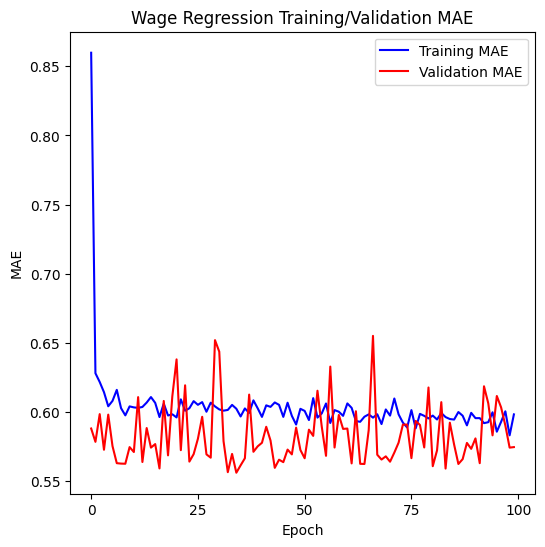

In [29]:
# Read the training results from the CSV log
wage_results = pd.read_csv(csv_logger.experiment.metrics_file_path)

# Create a plot to visualize training/validation MAE over epochs
fig, ax = subplots(1, 1, figsize=(6, 6))

# Filter data for training and validation MAE
train_data = wage_results.dropna(subset=['train_mae_epoch'])
valid_data = wage_results.dropna(subset=['valid_mae'])

# Plot training and validation MAE
ax.plot(train_data['epoch'], train_data['train_mae_epoch'], label='Training MAE', color='blue')
ax.plot(valid_data['epoch'], valid_data['valid_mae'], label='Validation MAE', color='red')

ax.legend()

# Customize the plot: set axis ticks, labels, and limits
ax.set_xticks(np.linspace(0, 100, 5).astype(int))
ax.set_ylabel('MAE')
ax.set_xlabel('Epoch')
ax.set_title('Wage Regression Training/Validation MAE')

The validation MAE is hovering around 0.55 to 0.65 standard deviations of the wage distribution, which is similar to the training MAE curve. Showing that the model doesn't overfit the data.

## Question 2

part A

In [ ]:
import torchvision
from torchvision.io import read_image
from torchvision.datasets import MNIST, CIFAR100
from torchvision.models import (resnet50,
                                ResNet50_Weights)
from torchvision.transforms import (Resize,
                                    Normalize,
                                    CenterCrop,
                                    ToTensor)
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [45]:
# Load image dataset
train_path = r'D:\william\OneDrive - UW-Madison\UW-Madison\722\MachineLearning25\cats_vs_dogs_dataset/train'
test_path = r'D:\william\OneDrive - UW-Madison\UW-Madison\722\MachineLearning25\cats_vs_dogs_dataset/test'

transform = torchvision.transforms.Compose([torchvision.transforms.Resize((64, 64)), torchvision.transforms.ToTensor(), torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

In [46]:
train_image_dataset = torchvision.datasets.ImageFolder(root=train_path, transform=transform)
test_image_dataset = torchvision.datasets.ImageFolder(root=test_path, transform=transform)

In [49]:
train_loader = DataLoader(train_image_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_image_dataset, batch_size=64, shuffle=False)

# Or use with SimpleDataModule if it accepts datasets
image_dm = SimpleDataModule(train_image_dataset, 
                           test_image_dataset, 
                           batch_size=64,
                           validation=0.25)

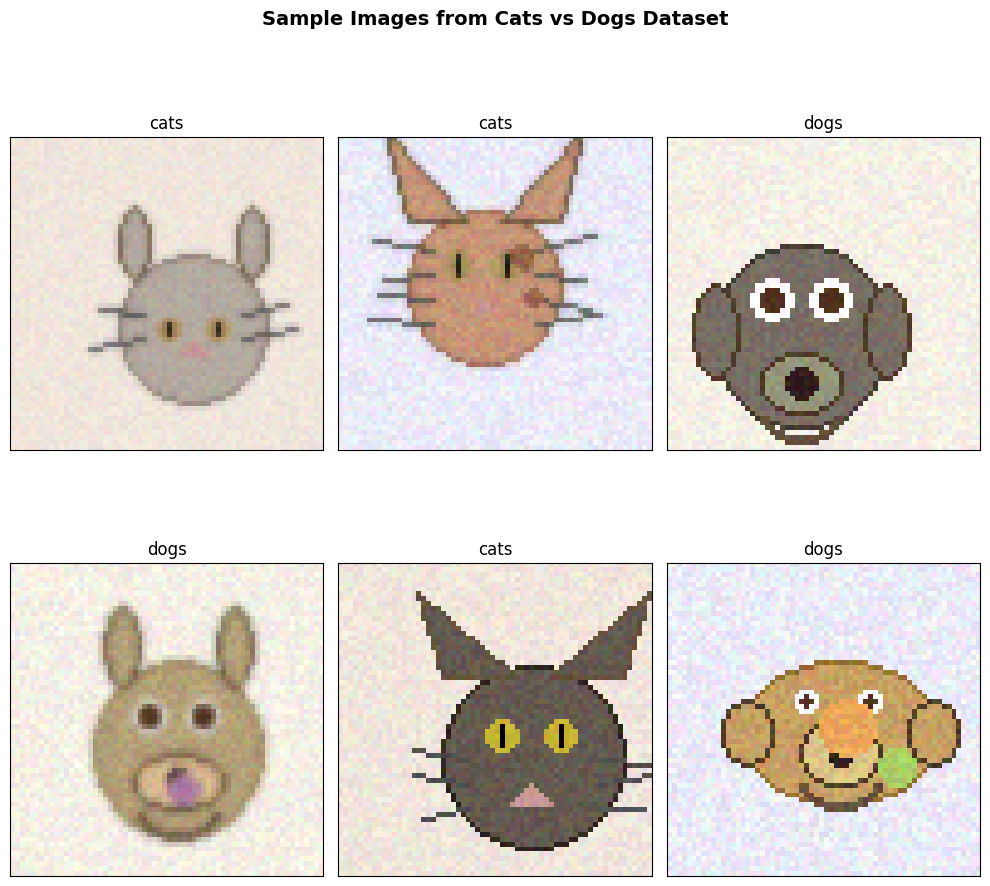

In [55]:
fig, axes = subplots(2, 3, figsize=(10,10)) 
rng = np.random.default_rng(72) 
indices = rng.choice(np.arange(len(train_image_dataset)), 6,
                     replace=False).reshape((2,3))
class_names = train_image_dataset.classes

for i in range(2): # Iterate over the rows of the 2x3 grid.
    for j in range(3): # Iterate over the columns of the 2x3 grid.
        idx = indices[i,j] # Get the index of the image to display.
        image, label = train_image_dataset[idx] # Get image and label from dataset
        
        image_np = image.numpy().transpose(1, 2, 0)
        
        image_np = (image_np + 1) / 2
        axes[i,j].imshow(image_np, interpolation=None) 
        axes[i,j].set_xticks([]) 
        axes[i,j].set_yticks([])
        axes[i,j].set_title(f'{class_names[label]}', fontsize=12)

plt.suptitle('Sample Images from Cats vs Dogs Dataset', 
             fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

part B

In [62]:
class CatDogCNN(nn.Module):
    def __init__(self): 
        
        super(CatDogCNN, self).__init__() # Initialize the parent class.
        
        # First convolutional block: Conv2d → ReLU → MaxPool2d
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # Second convolutional block: Conv2d → ReLU → MaxPool2d
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
   
        # Fourth convolutional block:
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 16 * 16, 128), 
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )
        
    def forward(self, x): 
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.fc_layers(x)
        return x

In [63]:
CatDog_model = CatDogCNN()
summary(CatDog_model, input_size=(64, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
CatDogCNN                                [64, 2]                   --
├─Sequential: 1-1                        [64, 16, 32, 32]          --
│    └─Conv2d: 2-1                       [64, 16, 64, 64]          448
│    └─ReLU: 2-2                         [64, 16, 64, 64]          --
│    └─MaxPool2d: 2-3                    [64, 16, 32, 32]          --
├─Sequential: 1-2                        [64, 32, 16, 16]          --
│    └─Conv2d: 2-4                       [64, 32, 32, 32]          4,640
│    └─ReLU: 2-5                         [64, 32, 32, 32]          --
│    └─MaxPool2d: 2-6                    [64, 32, 16, 16]          --
├─Sequential: 1-3                        [64, 2]                   --
│    └─Flatten: 2-7                      [64, 8192]                --
│    └─Linear: 2-8                       [64, 128]                 1,048,704
│    └─Dropout: 2-9                      [64, 128]                 --
│   

part C

In [77]:

CatDog_module = SimpleModule.classification(CatDog_model,
                                    num_classes=2)
CatDog_logger = CSVLogger("logs", name="CatDog_model")

# Create trainer with 100 epochs
CatDog_trainer = Trainer(
    deterministic=True,
    max_epochs=30,
    logger=CatDog_logger,
    callbacks=[ErrorTracker()]
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [78]:
CatDog_trainer.fit(CatDog_module, datamodule=image_dm)


  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | CatDogCNN        | 1.1 M  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.216     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 29: 100%|██████████| 12/12 [00:01<00:00,  6.53it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 12/12 [00:01<00:00,  6.42it/s, v_num=1]



In [80]:
# Test the model and report test MAE
CatDot_test_results = CatDog_trainer.test(CatDog_module, datamodule=image_dm)
print(f"Test MAE: {CatDot_test_results[0]['test_accuracy']:.2f}")

Testing DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 24.14it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          0.949999988079071
        test_loss           0.15934106707572937
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Test MAE: 0.95
Testing DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 24.14it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          0.949999988079071
        test_

part D

Text(0.5, 1.0, 'Cat/Dog Image Classification Accuracy')

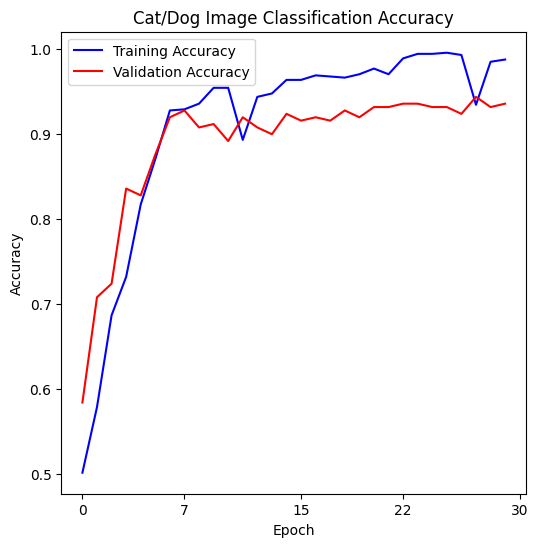

In [81]:
# Read the training results from the CSV log
CatDog_results = pd.read_csv(CatDog_logger.experiment.metrics_file_path)

# Create a plot to visualize training/validation Accuracy over epochs
fig, ax = subplots(1, 1, figsize=(6, 6))

# Filter data for training and validation Accuracy
train_data = CatDog_results.dropna(subset=['train_accuracy_epoch'])
valid_data = CatDog_results.dropna(subset=['valid_accuracy'])

# Plot training and validation Accuracy
ax.plot(train_data['epoch'], train_data['train_accuracy_epoch'], label='Training Accuracy', color='blue')
ax.plot(valid_data['epoch'], valid_data['valid_accuracy'], label='Validation Accuracy', color='red')

ax.legend()

# Customize the plot: set axis ticks, labels, and limits
ax.set_xticks(np.linspace(0, 30, 5).astype(int))
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_title('Cat/Dog Image Classification Accuracy')

CNNs preserve and exploit spatial relationships in image data through convolutional layers that detect local features and pooling layers that provide translation invariance, while the feedforward network in Q1 flattens the input features and loses all spatial structure by treating each feature independently. This architectural difference makes CNNs much more effective for image classification tasks where spatial patterns and local feature hierarchies are crucial for understanding the visual content.